<div style='width:500px; height:220px; border-bottom:10px black solid;border-left: 10px green solid;padding: 10px 10px 10px 10px;'>
    <h1> ---Portofolio Optimization Plot---</h1>
    <h3> Author: Jakob Lindstrøm </h3>
    <h3> Date: 03.05.2023 </h3>
</div>

<div style='width:600px; height:850px; padding: 10px 10px 10px 10px;border-bottom:10px black solid;
            border-left: 10px green solid'>
    <div>
        <h4>Keywords:</h4>
        <p> Stocks, portfolio, optimization, finance </p>
        <br>
        <p>License: CC-BY-NC</p>
        <h4> Data sources:  </h4>
        <p> yfinance: https://pypi.org/project/yfinance/ </p>
        <p> DNB markets: https://www.dnb.no/bedrift/markets/analyser/arkiv/anbefalteaksjer.html </p>
        <h4> Intention: </h4>
        <p> This programe has the final goal of forecasting a markovitz optimized portofolio. First a couple of stocks will be retrieved thorugh the yahoo finance library. Then the optimal portofolio will be generated using Markovitz portofolio theory. The past movement of this portofolio will be the subject of machine learning modelling. A multi-model machine learning algorithm will be used to fit a the model, and the model will then apply a recursive forecasting strategy to forecast future movements of the plot.  I use weekly recommened stock data from DNB markets. </p>
        <h4> Disclaimer: </h4>
        <p> The author do not take any responsibility for potential consequences thats been a result of using the code below. </p>
    </div>
</div>

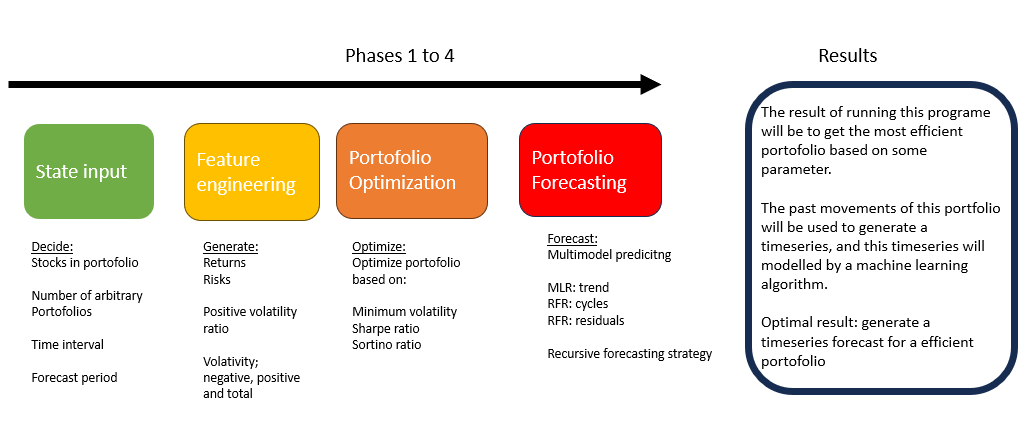

<h1> Table of content </h1>
<ol>
<li>Importing libraries</li>
<li>State input and retrieval</li>
<li>Feature engineering</li>
<li>Random portofolios</li>
<li>Optimization on Sharpe and Sortino</li>
<li>Plot over different portofolios</li>
<li>Machine Learning on time series</li>
<ol>
<li>Trend, MLR</li>
<li>Cycles, RFR_CV</li>
<li>Residuals, RFR_CV</li>

</ol>
<li>Forecasting</li>
<li>Summary</li>

</ol>

<em> Possible improvements:
<ol>
<li> Use logaritmic stock returns</li>
<li> Generate a random walk, with a modified distributions in accordance to each stock distributions</li>
<li> Investigate different ML-models for modelling cycles and residuals, maybe LSTM.</li>
<li> Make the time series component analysis more automized.</li>
<li> Come up with new ideas, for example include a modified random walk adjusted to a Cholensky matrix. </li>
<li> Create a dashboard either using bokeh or an application using tkinter </li>
<li> ...</li>

</ol></em>

<h1> 1. Importing libraries

In [218]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Diverse libraries
import random as rd
import math 
from math import sqrt

#Data libraries
import yfinance as yf   
from datetime import datetime

#Statistics libraries
import scipy.stats as st
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

#Optimization libraries
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

# from IPython.display import Image

#Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE

#Warning library
import warnings
warnings.filterwarnings("ignore")

<h1> 2. State input and retrieve it </h1>
<p> Below one shall state the input for the programme. Which stocks to include, for how long a time, how many arbitrary portofolios and the length of the forecast period. 

In [2]:
#INPUT FIELD:   
stocks = ['AKRBP.OL','BORR.OL','EPR.OL','EQNR.OL','LSG.OL','MOWI.OL','SRBNK.OL','SATS.OL']
#format: year-month-day
startPor = '2020-02-01'
hold_portofolio_days = 21
portofolio_Distributions = 50000
endDate = datetime.now().strftime('%Y-%m-%d')
#format: year-month-day
# endDate = '2023-01-29'

# Monte Carlo simulation
forecast_period = 40

In [3]:
#Retrieve financial data from yahoo finace


def dataRetriever():
    df = []
    for i in range(0,len(stocks),1):
        yahoo = yf.download(stocks[i], start=startPor, end=endDate)
        data = [0]
        for j in range(0, len(yahoo['Adj Close'])-1,1):
            selecive_data = ((yahoo['Adj Close'][j+1]/yahoo['Adj Close'][j])-1)
            data.append(selecive_data)
        adj_close = yahoo['Adj Close']
        relevant  = [stocks[i], data, adj_close]
        df.append(relevant)
    return df
mystocks = dataRetriever()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


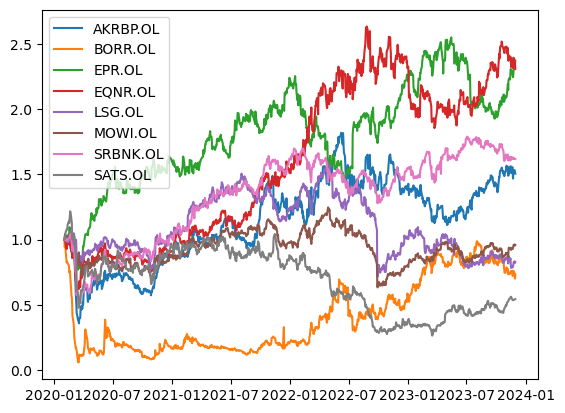

In [4]:
#Plot the past movement for the different stocks


fig, ax = plt.subplots()
for i in range(len(mystocks)):
    ax.plot(mystocks[i][2]/mystocks[i][2][0], label=stocks[i])
plt.legend()
plt.show()

<h1> 3. Feature engineering (ratios, risks and returns) </h1>
<p> This section of the programme will define vital information of the stocks. Covariance matrix, risks and returns.

In [5]:
#Create a ratio for the number of positive moves each stock has
#Add this ratio to the list of stocks


def pos_ratio():
    pos_ratio_list = []
    for i in range(0,len(mystocks),1):
        pos_ratio = np.where(np.array(mystocks[i][1])>0,1,0).sum()/len(mystocks[i][1])
        pos_ratio_list.append(pos_ratio)
    return pos_ratio_list

pos_ratio_stock = pos_ratio()

In [6]:
#Create mean returns for each stock


def means():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).mean())
    return np.array(means)
mean = means()

def stds():
    means = []
    for i in range(0,len(mystocks),1):
        means.append(pd.Series(mystocks[i][1]).std())
    return np.array(means)
std = stds()

In [7]:
#Create different portofolio risk matrices based 
#on total risk, downside risk and upside risk


total_cov_matrix = pd.DataFrame()
negative_cov_matrix =  pd.DataFrame()
positive_cov_matrix = pd.DataFrame()

for i in range(0, len(mystocks),1):
    total_cov_matrix[mystocks[i][0]] = mystocks[i][1]

    stock = pd.Series(mystocks[i][1])

    neg = stock.loc[stock < 0]
    negative_cov_matrix[mystocks[i][0]] = neg

    pos = stock.loc[stock > 0]
    positive_cov_matrix[mystocks[i][0]] = pos

negative_cov_matrix =  negative_cov_matrix.cov()
total_cov_matrix = total_cov_matrix.cov()
positive_cov_matrix = positive_cov_matrix.cov()

<h1> Random portofolios </h1>
<p> Now a various of portfolios will be generate and information about them will be added into a dataframe.

In [8]:
#Generate random weigths for all stocks in each portofolio n times


def portofolio_generator():
    portofolios = []
    for i in range(0,portofolio_Distributions,1):
        single = np.random.dirichlet(np.ones(len(stocks)),size=1)
        portofolios.append(single)
    return portofolios
portofolios = portofolio_generator()

In [9]:
#Create returns for each portofolio


def portofolioReturns(ps):
    returns = []
    for i in range(0, len(ps),1):
        returns.append(sum(mean@ps[i].T))
    return returns
returns = portofolioReturns(portofolios)

In [10]:
# Generate standard deviation for portofolios
# ps = portofolios, cov = covariance matrix

def portofolio_std(ps, cov):
    #ps is short for portofolios
    pstd = [(ps[i] @ cov @ ps[i].T)**.5 for i in range(len(ps))]
    portofolio_std = pd.Series([pstd[i][0][0] for i in range(len(ps))])

    return portofolio_std



#Calculate the different risktypes for each portofolio
neg_risk = portofolio_std(portofolios, negative_cov_matrix)
tot_risk = portofolio_std(portofolios, total_cov_matrix)
pos_risk = portofolio_std(portofolios, positive_cov_matrix)

In [11]:
#Create a function to predict the ratio of 
#positive moves a portofolio will have


def por_pos_ratio(ps):
    por_pos_ratio = [ps[i][0]@(np.array(pos_ratio_stock)-0.5) 
                     for i in range(len(ps))]

    return por_pos_ratio
por_movement_ratio_dir = por_pos_ratio(portofolios)


In [263]:
#Create a dataframe containing all portofolios
#with a predicted return over 0%


def dfOutput():
    
    df = pd.DataFrame()
    colnames =  ['Weigths', 'Return', 'Total_risk','Negative_risk', 'Positive_risk','Pos_risk_ratio']
    colvalues = [portofolios, returns, tot_risk, neg_risk, pos_risk, por_movement_ratio_dir]
    
    for i in range(0,len(colnames),1):
        df[colnames[i]] = colvalues[i]
    df['Sharpe_Ratio'] = df['Return']/(df['Total_risk'])
    df['Sharpe_Ratio'] = colvalues[1]/(colvalues[2])
    df['Sortino_Ratio'] =df['Return']/(df['Negative_risk']+1)
    df = df.loc[df['Return'] >= 0].reset_index()
    del df['index']

    return df
df = dfOutput()

<h1> Optimzation on Sharpe and Sortino

Now that the feature engineering part is done, one can optimize a portofolio. I have choosen to optimze three portofolios in regard to minimum variance, highest Sortino ratio and highest Sharpe ratio.  <br>
<p> Inspiration: https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization </p>

In [264]:
c1 = Bounds(0,1)

#Creating arbitrary values for weigths
c2 = LinearConstraint(np.ones((len(stocks),), dtype=int),1,1)

#Creating arbitrary values for the weigths
weigths = np.ones(len(stocks))
#And making them add up to 100%.
decVar = weigths/np.sum(weigths)


opt_port = []
opt_spec = ['Minimum Variance', 'Highest Sortino', 'Highest Sharpe']
special_params = [total_cov_matrix,negative_cov_matrix,total_cov_matrix]
for i in range(0,3,1):
    if  i ==0:  
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)
    else:
        Z = lambda w: np.sqrt(w@special_params[i]@w.T)/(mean@w)

    res = minimize(Z, decVar, method='trust-constr', constraints = c2, bounds = c1)
    w = res.x
    ret = sum(w*mean)
    risk = (w@total_cov_matrix@w.T)**.5
    opt_port.append([w, ret, risk, opt_spec[i]])


<h1> 6 Plot over different portofolios

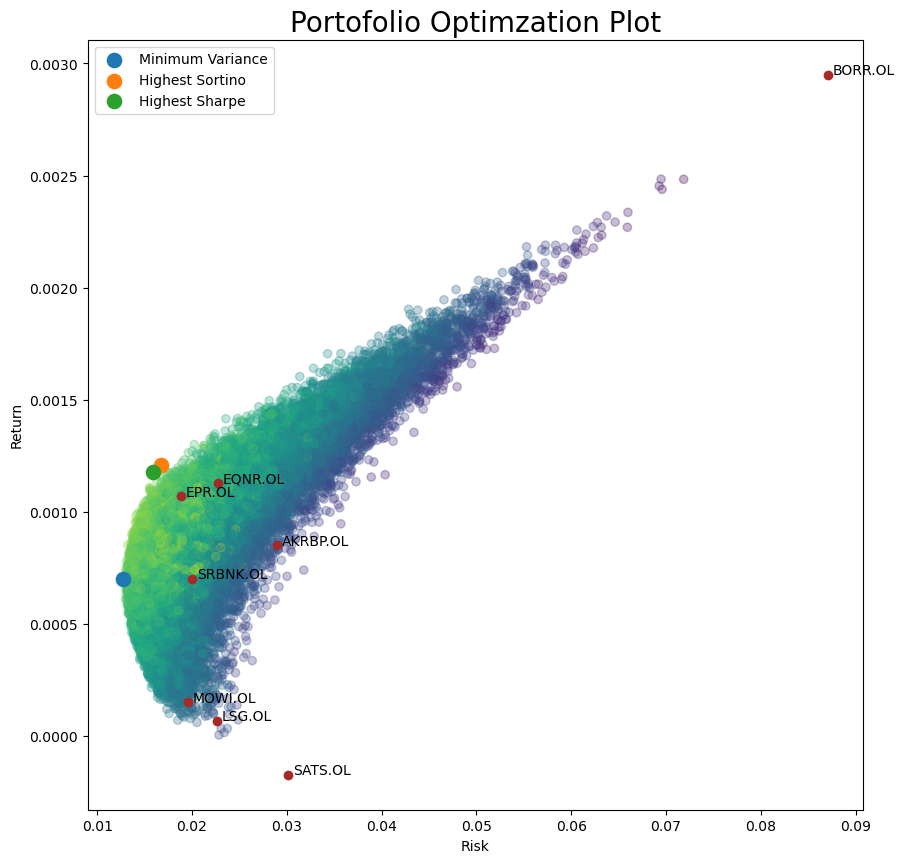

In [265]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y=returns, x=tot_risk, c=df['Pos_risk_ratio'],
           marker='o', alpha=.3)

for i in range(3):
    ax.scatter(x=opt_port[i][2],y=opt_port[i][1], label=opt_port[i][3], s=105)

ax.scatter(y=mean, x= std,color='brown')
for i in range(len(stocks)):
    plt.annotate(stocks[i], (std[i]+0.0005,mean[i]))
plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.title('Portofolio Optimzation Plot', fontsize=20)
plt.show()
# plt.savefig('opt_ex.png')

Looking at the plot above one can see how the risk and returns varies from different weigths in the portofolio. I will personally choose the portofolio with the highest Sharpe ratio, and try to model it.

In [336]:
# Choosing my portfolio, I choose the highest sharpe ratio
# state i! 
# 0 = MinVar
# 1 = Sortino
# 2 = Sharpe
i = 1

best_por = opt_port[2]
print(best_por[3])
print('Stock distributions:')
pd.DataFrame([round(best_por[0][i],2) for i in range(0,len(stocks),1)], index=stocks).transpose()

Highest Sharpe
Stock distributions:


,AKRBP.OL,BORR.OL,EPR.OL,EQNR.OL,LSG.OL,MOWI.OL,SRBNK.OL,SATS.OL
0,0.0,0.05,0.58,0.34,0.0,0.0,0.03,0.0


In [337]:
best_por

[array([5.42837526e-08, 5.17312901e-02, 5.83254584e-01, 3.37736957e-01,
        7.34844291e-08, 1.44290143e-07, 2.72768677e-02, 2.88645254e-08]),
 0.0011759588843917482,
 0.01592477226716058,
 'Highest Sharpe']

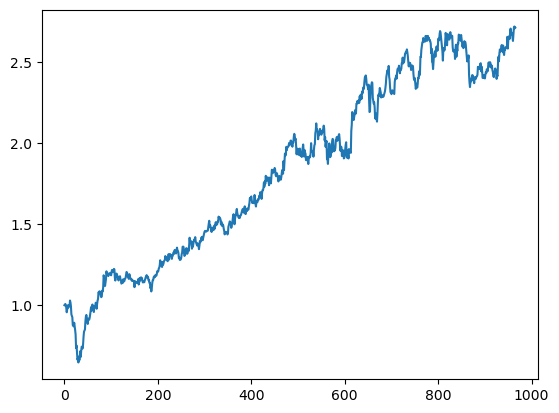

In [338]:
time_cum = []
for i in range(0, len(mystocks[0][1])):
    day_cum = []
    day_sel = 0

    for j in range(0,len(best_por),1):
        day_sel += best_por[0][j]*mystocks[j][1][i]
        if j == (len(best_por)-1):
            
            day_cum.append(day_sel+1)
    time_cum.append(day_cum[0])

portofolio_actual_movement = pd.Series(np.cumprod(time_cum))
portofolio_actual_movement.plot()
plt.show()

<h1>7 Machine Learning on time series </h1>
<p> Now I will try to create a ML model that can forecast my choosen portofolio. I will use all the different time series components, except for seasonality. In other words; I will try to capture the trend, cycles and seasonality of the time series. I will use a recursive strategy for forecasting. <br>
<p> Inspiration: https://www.kaggle.com/learn/time-series </p>

<h2> 7.1 MLR on trend

In [339]:
#Creating X and y ffeature for capturing the trend


y = portofolio_actual_movement.copy()
dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=2,
                          drop=True)
X = dp.in_sample()


In [340]:
# Splitting the data into different sets
def tts(X,y):
    idx_train, idx_test = train_test_split(y.index,
                                        test_size=60,
                                        random_state=42,
                                        shuffle=False)
    X_train, y_train = X.loc[idx_train,:], y.loc[idx_train]
    X_test, y_test = X.loc[idx_test,:], y.loc[idx_test]
    return [X_train,y_train, X_test,y_test]

first_split = tts(X, portofolio_actual_movement)
X_train, y_train = first_split[0],first_split[1]
X_test, y_test = first_split[2], first_split[3]

In [341]:
fit_idx = np.linspace(0, len(X_train), len(X_train))
pred_idx = np.linspace(len(y_train)+1, len(y_train)+len(X_test),len(X_test))

In [342]:
# Fitting a linear regression model to capture trend
model_trend = LinearRegression()
model_trend.fit(X_train, y_train)

# Predict the train and test set
y_fit_trend = pd.Series(model_trend.predict(X_train),
                  index=y_train.index)

y_pred_trend = pd.Series(model_trend.predict(X_test), 
                      index=y_test.index)

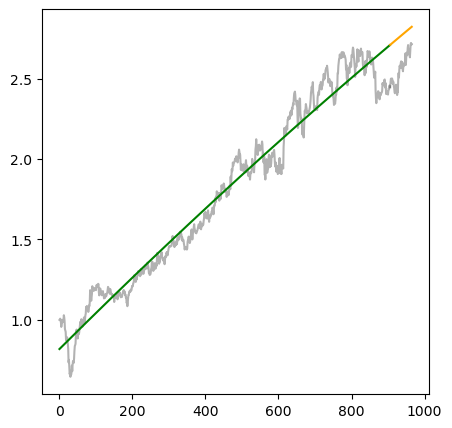

In [343]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y_train, color='black', alpha=.3)
ax.plot(y_test, color='black', alpha=.3)

ax.plot(y_fit_trend,color='green')
ax.plot(y_pred_trend, color='orange')

<h2> 7.2 RFR on cycles </h2>
<p> This cycle section hasnt been automized yet. Here its important to choosen the number of lagged variables one want. This input shall go in to the "generate_lags" function.

In [344]:
#Generating different models
def grid_searcher(depth_int='', nest_int=''):

    models = []
    for i in range(0,len(depth_int),1):
        for j in range(0,len(nest_int),1):
            sel_model = RandomForestRegressor(random_state=42,
                                              max_depth=int(depth_int[i]),
                                              n_estimators=int(nest_int[j]))
            models.append(sel_model)
    return models

#Running cross_validation on time series
def timeSeriesCV(model='', train='', test='', cv=''):
    baseline = 0.5
    baselen = len(X_train)
    split = 0.5/(cv+1)

    scores = []
    for i in range(0,cv,1):
        ref_idx_train = int(baselen*((split*i)+baseline))
        ref_idx_test = int(baselen+((split*i+1)+baseline))

        sel_X_train = train.iloc[:ref_idx_train]
        sel_y_train = test.iloc[:ref_idx_train]

        sel_X_test = train.iloc[ref_idx_train: ref_idx_test]
        sel_y_test = test.iloc[ref_idx_train: ref_idx_test]


        model.fit(sel_X_train,sel_y_train)
        test_pred = model.predict(sel_X_test)
        scores.append(MAPE(test_pred,sel_y_test))
    
    return np.mean(scores)

#Finding best model
def best_model(depth_int, nest_int, train, test, cv):
    models =  grid_searcher(depth_int, nest_int)

    results = []
    for i in range(0,len(models),1):
        score = timeSeriesCV(model=models[i], train=train, test=test, cv=cv)
        model = models[i]
        results.append([score,model])

    low = min([results[i][0] for i in range(len(results))])
    idx = np.where([results[i][0] for i in range(len(results))]== low)

    best_model = results[int(idx[0])][1]
    return best_model
    # return results

In [345]:
def generate_lags(data, n_lags):
    df = pd.DataFrame()
    for i in range(1,n_lags+1,1):
        df['lag'+str(i)] = data.shift(i, fill_value=1)
    return df


def normalize(arr):
    answer = (arr-arr.mean())/arr.std()
    return answer

def rev_normalize(org_data, new_data):
    mean = org_data.mean()
    std =  org_data.std()
    actual_new_data = new_data*std+mean
    return actual_new_data


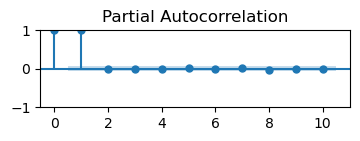

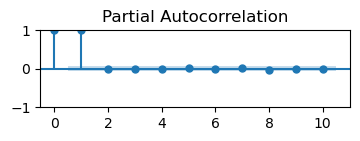

In [346]:
fig, ax = plt.subplots(figsize=(4,1))
plot_pacf(y, lags=10, ax=ax)

In [347]:
X_train_cyc = generate_lags(y_train,1)
X_test_cyc = generate_lags(y_test,1)

y_train_cyc = (y_train - y_fit_trend)
y_test_cyc = (y_test - y_pred_trend)

In [348]:
model_cyc = best_model(np.linspace(4,12,8),  np.linspace(5,13,9), X_train_cyc, y_train_cyc, cv=7)
model_cyc.fit(X_train_cyc,y_train_cyc)

RandomForestRegressor(max_depth=5, n_estimators=9, random_state=42)

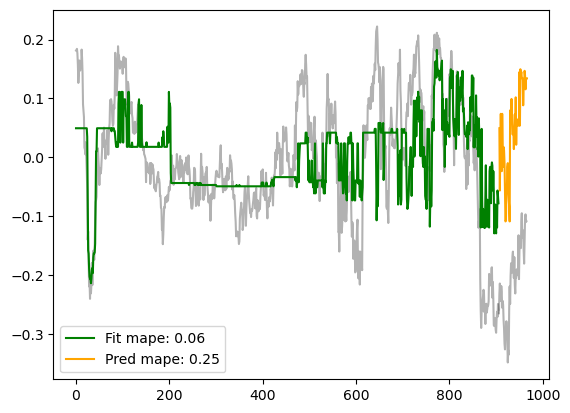

In [349]:
y_fit_cyc = model_cyc.predict(X_train_cyc)
y_pred_cyc = model_cyc.predict(X_test_cyc)
mape_fit_cyc = round(MAE(y_fit_cyc, y_train_cyc),2)
mape_pred_cyc  = round(MAE(y_pred_cyc, y_test_cyc),2)

fig, ax = plt.subplots()
ax.plot(y_train_cyc, color='black', alpha=.3)
ax.plot(y_test_cyc, color='black', alpha=.3 )
ax.plot(y_fit_cyc, color='green', 
        label='Fit mape: '+str(mape_fit_cyc))
ax.plot(pred_idx,y_pred_cyc, color='orange', 
        label='Pred mape: '+str(mape_pred_cyc))
plt.legend()
plt.show()

<h2> 7.3 RFR on residuals </h2>


In [350]:
# Define new target variable
y_train_resid = y_train - y_fit_trend - y_fit_cyc
y_test_resid = y_test - y_pred_trend -  y_pred_cyc

# Define new explanatory variables
X_train_resid = pd.concat([X_train, X_train_cyc],axis=1)
X_test_resid = pd.concat([X_test, X_test_cyc], axis=1)

In [351]:
model_resid = best_model(np.linspace(4,12,8),  np.linspace(5,13,9), X_train_resid, y_train_resid, cv=7)
model_resid.fit(X_train_resid,y_train_resid)

RandomForestRegressor(max_depth=4, n_estimators=11, random_state=42)

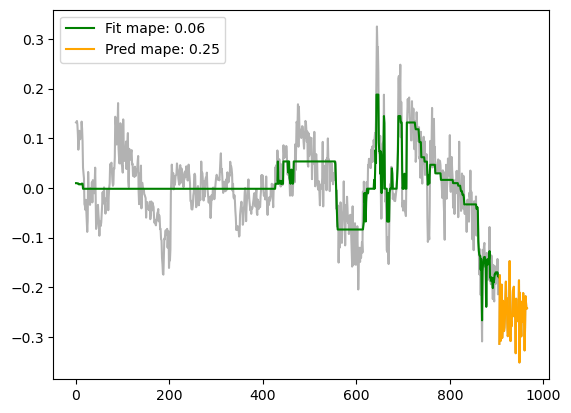

In [352]:
y_fit_resid = model_resid.predict(X_train_resid)
y_pred_resid = model_resid.predict(X_test_resid)

mape_fit_resid = round(MAPE(y_fit_resid, y_train_resid),2)
mape_pred_resid  = round(MAPE(y_pred_resid, y_test_resid),2)


fig, ax = plt.subplots()
ax.plot(y_train_resid, color='black', alpha=.3)
ax.plot(y_test_resid, color='black', alpha=.3)

ax.plot(y_fit_resid, color='green',
         label='Fit mape: '+str(mape_fit_cyc))
ax.plot(y_test_resid, color='orange',
        label='Pred mape: '+str(mape_pred_cyc))
plt.legend()
plt.show()

<h1> 8 Forecasting </h1>
<p> Now I will try to forecast the model based on my previous findings. The forecasting will be using all of the tree models, and I will use a recursive forecasting strategy.

In [353]:
final_fit  = y_fit_trend + y_fit_cyc + y_fit_resid
final_pred = y_pred_trend.reset_index()[0] + y_pred_cyc + y_pred_resid

final_fit_mae = round(MAPE(final_fit, y_train),2)
final_pred_mae = round(MAPE(final_pred, y_test),2)

In [354]:
# Multimodel function for forecasting values


def multi_model(pred):

    new_y1 = model_trend.predict(pred.loc[:,: 'trend_squared'])

    new_y2 = model_cyc.predict(pred[['lag1']])

    new_y3 = model_resid.predict(pred)

    new_forecast = new_y1[0] + new_y2[0] + new_y3[0]
    return new_forecast

In [355]:
# Forecast function that uses a Recursive strategy

def recursive():
    forecast_features = pd.DataFrame(columns= ['const', 'trend', 'trend_squared', 'lag1'], index=[0])
    previous_row = X_test_resid.iloc[-1:].reset_index()
    forecasts = []

    for i in range(0,  40,1):
        if i == 0:
            previous_target = y_test[-1:].reset_index()[0][0]
        else:
            previous_target = forecasts[-1]

        new_row = [1, 
                previous_row['trend'][0]+i,
                (previous_row['trend'][0]+i)**2,
                previous_target]
        new_pred = pd.DataFrame({'const':new_row[0],
                                'trend':new_row[1],
                                'trend_squared':new_row[2],
                                'lag1':new_row[3]}, 
                                index=[i])
        
        forecasts.append(multi_model(new_pred))


        forecast_features.loc[i] = new_row
    
    return [forecasts, forecast_features]


In [356]:
forecasts = recursive()[0]
for_idx = np.linspace(len(y)+1, len(y)+len(forecasts),forecast_period)

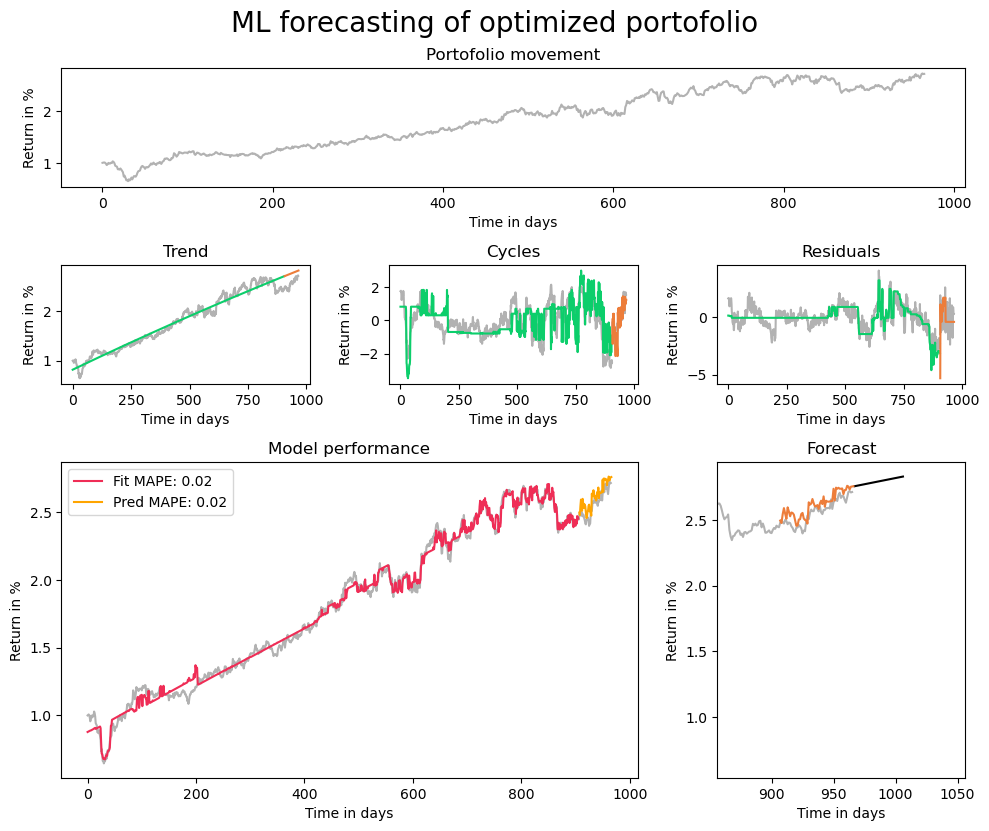

In [357]:
pam = portofolio_actual_movement
fig = plt.figure(figsize=(10,10))

ax0 = plt.subplot2grid((5,3),(0,0), colspan=3, rowspan=1)
ax0.plot(pam, color='black', alpha=.3)

ax1 = plt.subplot2grid((5,3),(1,0)) 
ax1.plot(pam,color='black', alpha=.3)
ax1.plot(y_fit_trend, color='#0CCE6B')
ax1.plot(pred_idx, y_pred_trend, color='#ED7D3A')

ax2 = plt.subplot2grid((5,3),(1,1))
ax2.plot(normalize(y_train_cyc), color='black', alpha=.3)
ax2.plot(normalize(y_test_cyc), color='black', alpha=.3)
ax2.plot(normalize(y_fit_cyc), color='#0CCE6B')
ax2.plot(pred_idx, normalize(y_pred_cyc), color='#ED7D3A')


ax3 = plt.subplot2grid((5,3),(1,2)) 
ax3.plot(normalize(y_train_resid), color='black', alpha=.3)
ax3.plot(normalize(y_test_resid), color='black', alpha=.3)
ax3.plot(normalize(y_fit_resid), color='#0CCE6B')
ax3.plot(pred_idx, normalize(y_pred_resid), color='#ED7D3A')

ax4 = plt.subplot2grid((5,3),(2,0), colspan=2, rowspan=2)
ax4.plot(pam, color='black', alpha=.3)
ax4.plot(final_fit, color='#EF2D56', label='Fit MAPE: '+str(final_fit_mae))
ax4.plot(pred_idx, final_pred, color='orange', label='Pred MAPE: '+str(final_pred_mae))
plt.legend()


ax5 = plt.subplot2grid((5,3),(2,2), rowspan=2)
ax5.plot(pam, color='black', alpha=.3)
ax5.plot(for_idx, forecasts, color='black')
ax5.plot(pred_idx, final_pred, color='#ED7D3A')
ax5.set_xlim(len(X_train)-50)

axes = [ax0,ax1,ax2,ax3,ax4,ax5]
axes_names = ['Portofolio movement','Trend','Cycles','Residuals', 'Model performance','Forecast']
for i in range(len(axes)):
    axes[i].set_title(axes_names[i])
    axes[i].set_xlabel('Time in days')
    axes[i].set_ylabel('Return in %')

# fig.sub_title('sd')
fig.suptitle('ML forecasting of optimized portofolio', fontsize=20)

fig.tight_layout()
plt.show()
# plt.savefig('for_ex.png')

<h1> 9 Summary </h1>
<p> 
    To start I will mention that this programme is under development and has a lot of planned improvments.
</p>
<br>
<p> 
Now I will comment my findings on the timeseries multiplot. It seems like the model has a good ability to capture trends, cycles and residuals. The fitted and predicted line do not follow the timeseries very accurately, this might indicate that the algorithm is underfitting...
</p>
<ol> 
    <li> 
        The trend  prediction seems to capture the actual trend quite good. Do the nature of the timeseries its plausible to believe that the trend is exponential, and then quadratic.
    </li>
    <li> 
        The model seems to capture the cycles quite well. However, the fitted and predicted line has several points where its quite stable and therefore it may indicate that the model is underfitting. 
    </li>
    <li> 
        The model on residuals seems to encounter the same situation as the previous model.
    </li>
</ol>
<p> 
    An inital thought about the time series model is that the model has potential of capturing both the cycles and residuals better. One possible  way of countering this problem is to do some better finetuning og using different models. 
</p>
<em><h3> This programme is in a development phase </h3> </em>

